<a href="https://colab.research.google.com/github/commitit/Stock-Prediction/blob/main/stock_predictionv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting the stock price movement of American Express.

* We are using the stock data for American Express from the year 1972 to 2020 and try to predict the closing price for 30 days.

* Closing Price is the last price at which a stock trades during a regular trading session.

# Importing required libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import tensorflow as tf

import datetime

# Data Exploration

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/commitit/Stock-Prediction/main/AXP.csv")

In [ ]:
df.head(105)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1972-06-01,3.693287,3.693287,3.693287,3.693287,0.406085,0.0
1,1972-06-02,3.677195,3.677195,3.677195,3.677195,0.404316,0.0
2,1972-06-05,3.604777,3.604777,3.604777,3.604777,0.396353,0.0
3,1972-06-06,3.411664,3.411664,3.411664,3.411664,0.375120,0.0
4,1972-06-07,3.371432,3.371432,3.371432,3.371432,0.370696,0.0
...,...,...,...,...,...,...,...
100,1972-10-23,3.926632,3.926632,3.926632,3.926632,0.431742,0.0
101,1972-10-24,3.958818,3.958818,3.958818,3.958818,0.435281,0.0
102,1972-10-25,3.958818,3.958818,3.958818,3.958818,0.435281,0.0
103,1972-10-26,3.958818,3.958818,3.958818,3.958818,0.435281,0.0


In [ ]:
# We take a look at the last rows of our dataset
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
12059,2020-03-26,92.239998,99.690002,90.839996,93.290001,92.774651,9459400.0
12060,2020-03-27,87.940002,91.970001,85.820000,88.730003,88.239845,6999800.0
12061,2020-03-30,88.510002,91.389999,85.269997,90.269997,89.771332,5565000.0
12062,2020-03-31,89.940002,90.900002,85.070000,85.610001,85.137077,6075900.0
12063,2020-04-01,80.650002,81.309998,77.000000,77.839996,77.409996,8307600.0


In [ ]:
# We check the datatype and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12064 entries, 0 to 12063
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       12064 non-null  object 
 1   Open       12064 non-null  float64
 2   High       12064 non-null  float64
 3   Low        12064 non-null  float64
 4   Close      12064 non-null  float64
 5   Adj Close  12064 non-null  float64
 6   Volume     12064 non-null  float64
dtypes: float64(6), object(1)
memory usage: 659.9+ KB


In [ ]:
#Convert "Date" column to datetime format and set Date as an index
df["Date"] = pd.to_datetime(df["Date"])
df.index = df.pop("Date")

In [ ]:
df = df[["Close"]]

In [ ]:
df.head()

,Close
Date,
1972-06-01,3.693287
1972-06-02,3.677195
1972-06-05,3.604777
1972-06-06,3.411664
1972-06-07,3.371432


In [ ]:
df.describe()

,Close
count,12064.000000
mean,29.681398
std,30.876242
min,1.134539
25%,4.747363
50%,13.038323
75%,47.703850
max,136.929993


# Data Visualization

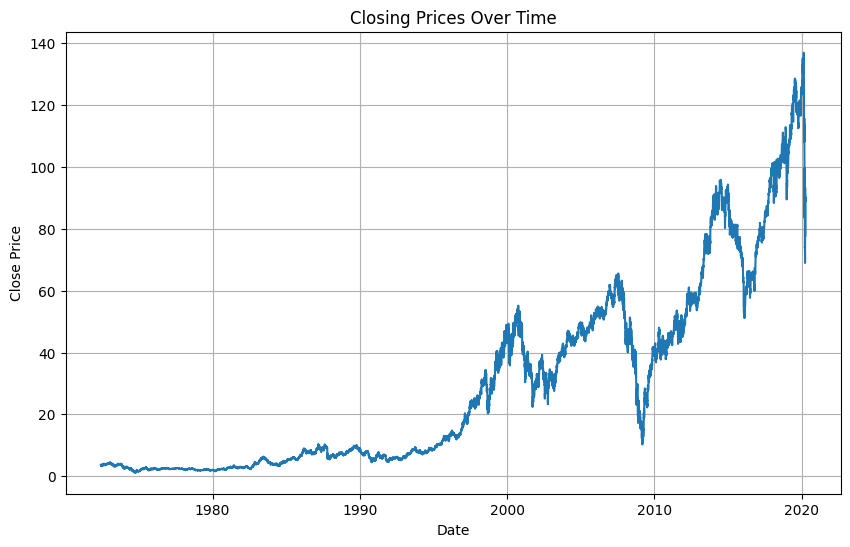

In [ ]:
#Visualizing the closing price from 1972 until 2020
plt.figure(figsize=(10, 6))
plt.plot(df)
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

# Data Preparation

###Splitting the data to Training and Test data
####Importing MinMaxScaler from scikit-learn to scale our dataset into numbers between 0 and 1

In [ ]:
#For preprocessing
from sklearn.preprocessing import MinMaxScaler

#For model evaluation
from sklearn.metrics import mean_squared_error as mse

In [ ]:
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df).reshape(-1,1))
df1

array([[0.01884266],
       [0.01872416],
       [0.01819087],
       ...,
       [0.65639501],
       [0.62207872],
       [0.56486027]])

In [ ]:
#Create a new DataFrame with the scaled values and original dates in the index
scaled_df = pd.DataFrame(df1, index = df.index, columns = ["Scaled_Close"])
scaled_df.head()

,Scaled_Close
Date,
1972-06-01,0.018843
1972-06-02,0.018724
1972-06-05,0.018191
1972-06-06,0.016769
1972-06-07,0.016473


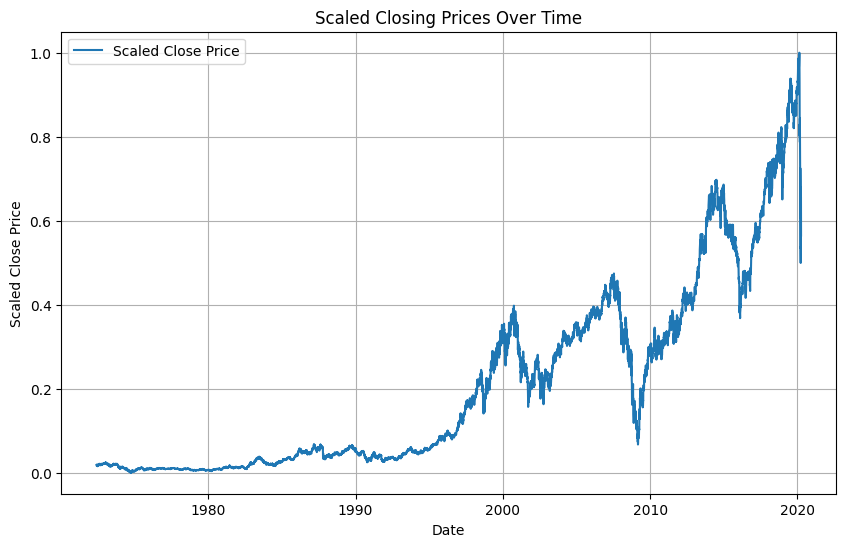

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scaled_df.index, scaled_df["Scaled_Close"], label="Scaled Close Price")
plt.title('Scaled Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.grid(True)
plt.show()

We will use a 80% and 20% split for the training and test sets.

In [ ]:
#Determining Training Size: 80% of the total dataset length
training_size = int(len(df1)*0.8)

#Determining Test Size: remaining 20% of the total dataset length
test_size = len(df1)-training_size

In [ ]:
#Inspecting the sizes of our training and test sets
print ("Training Size: ", training_size)
print ("Test Size: ", test_size)

Training Size:  9651
Test Size:  2413


In [ ]:
# Splitting Dataset: train_data contains the first training_size rows of the scaled data, and test_data contains the remaining rows.
train_data,test_data=df1[0:training_size,:], df1[training_size:len(df1),:1]

In [ ]:
#Checking the  length (number of rows) in our training and test set

print("Length of Training Data:", len(train_data))
print("Length of Test Data:", len(test_data))


Length of Training Data: 9651
Length of Test Data: 2413


In [ ]:
#Inspecting the train data as NumPy array
train_data

array([[0.01884266],
       [0.01872416],
       [0.01819087],
       ...,
       [0.28421762],
       [0.29290716],
       [0.28539586]])

# Linear Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
train_data

array([[0.01884266],
       [0.01872416],
       [0.01819087],
       ...,
       [0.28421762],
       [0.29290716],
       [0.28539586]])

In [ ]:
test_data

array([[0.28524858],
       [0.2940854 ],
       [0.29268625],
       ...,
       [0.65639501],
       [0.62207872],
       [0.56486027]])

Set the timestep to 100


> time_step (int): The number of time steps to use for each input sequence.



Convert the time series array into input-output pairs for an autoregressive model.
Return a tuple containing NumPy arrays (X, Y), where X is the input sequence matrix and Y is the target values array

In [ ]:
#Function to create X, Y numpy arrays
def create_dataset2(stock_data, time_step=1):
	X, Y = [], []
	for i in range(len(stock_data)-time_step):
		a = stock_data[i:(i+time_step), 0]
		X.append(a)
		Y.append(stock_data[i+time_step,0])
	return np.array(X), np.array(Y)

In [ ]:
#Calling the create_dataset function to create input-output pairs for our training and test sets with a time step of 100
time_step = 100
x_train_lr, y_train_lr = create_dataset2(train_data, time_step)
x_test_lr, y_test_lr = create_dataset2(test_data, time_step)

In [ ]:
x_train_lr.shape

(9551, 100)

In [ ]:
y_train_lr.shape

(9551,)

In [ ]:
# Create LinearRegression Object
LR_model = LinearRegression()
# Fit linear model using the train data set
LR_model.fit(x_train_lr, y_train_lr)

LinearRegression()

In [ ]:
train_pred_lr = LR_model.predict(x_train_lr)
test_pred_lr = LR_model.predict(x_test_lr)

In [ ]:
from sklearn.metrics import mean_absolute_error

#evaluation metrics
#lower MAE is better
#closer model correlation coefficient to 1.0 the better
LR_mse = mean_absolute_error(y_test_lr,test_pred_lr)
LR_rmse =np.sqrt(LR_mse)
print("Mean absolute error: ", LR_mse)
print("R squared error: ", LR_rmse)

Mean absolute error:  0.0059930556639482165
R squared error:  0.07741482845003415


In [ ]:
test_pred_lr

array([0.32934878, 0.32882991, 0.32026049, ..., 0.63760571, 0.65789192,
       0.61449757])

In [ ]:
y_test_lr

array([0.32884357, 0.32155318, 0.31904941, ..., 0.65639501, 0.62207872,
       0.56486027])

In [ ]:
train_pred_lr=train_pred_lr.reshape(1, -1)
test_pred_lr=test_pred_lr.reshape(1, -1)

#Inverse transform to get the actual values
train_pred_n = scaler.inverse_transform(train_pred_lr)
test_pred_n = scaler.inverse_transform(test_pred_lr)


In [ ]:
test_pred_n

array([[45.85860595, 45.78814546, 44.62445812, ..., 87.71849526,
        90.47327056, 84.58051498]])

In [ ]:
train_pred_n = train_pred_n.reshape(-1,1)
test_pred_n = test_pred_n.reshape(-1,1)


In [ ]:
len(train_pred_n)

9551

In [ ]:
P_train_lr=df[time_step:len(train_pred_n)+time_step]
P_train_lr = pd.DataFrame(train_pred_n, index = P_train_lr.index, columns = ["Predicted_Close"])
len(P_train_lr)


9551

We check our predictions of the closing price based on the training set and then display the first 5 rows

In [ ]:
P_train_lr.head()

,Predicted_Close
Date,
1972-10-23,3.983632
1972-10-24,3.939278
1972-10-25,3.979508
1972-10-26,3.986461
1972-10-27,3.975788


In [ ]:
P_test_lr=df[-len(test_pred_n):]
P_test_lr = pd.DataFrame(test_pred_n, index = P_test_lr.index, columns = ["Predicted_Close"])
len(P_test_lr)

2313

We check our predictions of the closing price based on the testing set and then display the last 5 rows

In [ ]:
P_test_lr.tail()

,Predicted_Close
Date,
2020-03-26,90.118887
2020-03-27,93.197539
2020-03-30,87.718495
2020-03-31,90.473271
2020-04-01,84.580515


In [ ]:
df.tail()

,Close
Date,
2020-03-26,93.290001
2020-03-27,88.730003
2020-03-30,90.269997
2020-03-31,85.610001
2020-04-01,77.839996


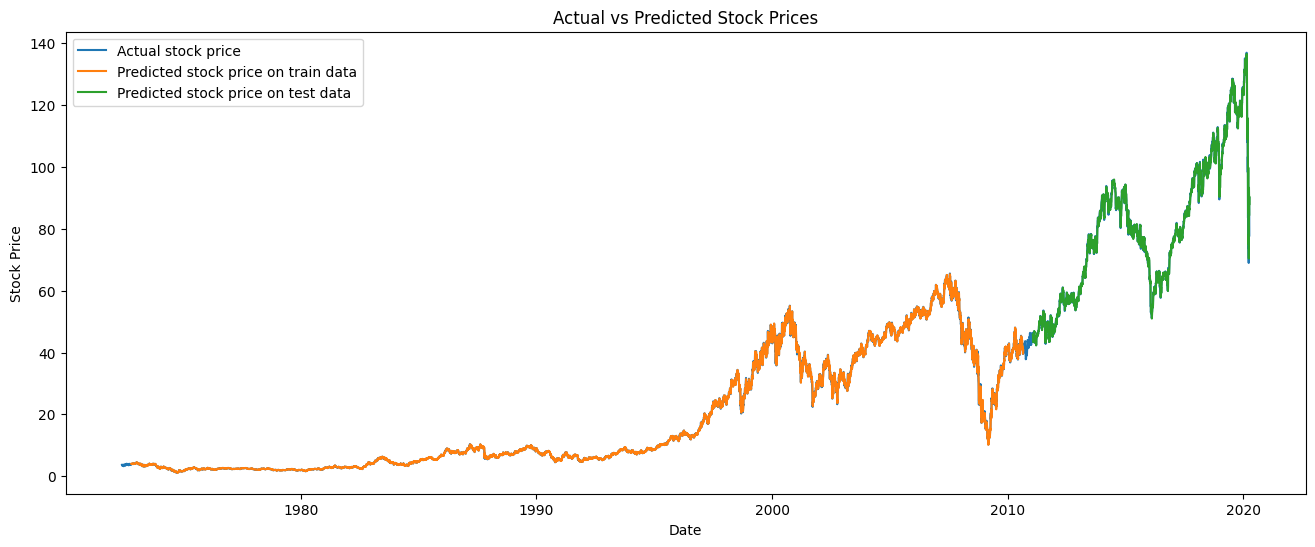

In [ ]:
plt.figure(figsize=(16,6))

plt.plot(df, label = "Actual stock price")
plt.plot(P_train_lr, label = "Predicted stock price on train data")
plt.plot(P_test_lr, label = "Predicted stock price on test data")

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

# Preparing the data for LSTM
* Set the timestep to 100
  * time_step (int): The number of time steps to use for each input sequence.
* Convert the time series array into input-output pairs for an autoregressive model.
* Return a tuple containing NumPy arrays (X, Y), where X is the input sequence matrix and Y is the target values array.

In [ ]:
#Function to create X, Y numpy arrays
def create_dataset(stock_data, time_step=1):
	X, Y = [], []
	for i in range(len(stock_data)-time_step):
		a = stock_data[i:(i+time_step), 0]
		X.append(a)
		Y.append(stock_data[i+time_step,0])
	return np.array(X), np.array(Y)


In [ ]:
#Calling the create_dataset function to create input-output pairs for our training and test sets with a time step of 100
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [ ]:
print("Shape of X_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (9551, 100)
Shape of y_train: (9551,)


In [ ]:
print("Shape of X_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_test: (2313, 100)
Shape of y_test: (2313,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

# Build the Model
Add LSTM layer along with dropout layers to prevent overfitting. After that, we add a Dense layer that specifies a one unit output. Next, we compile the model using the adam optimizer and set the loss as the mean_squarred_error

In [ ]:
### Creating the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

model=Sequential()

model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(Dropout(0.2))

model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(32, activation = "relu"))
model.add(Dense(32, activation = "relu"))

model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam', metrics = ["mean_absolute_error"])

modelresult = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100, batch_size=64,verbose=1)


Epoch 1/25
150/150 [==============================] - 17s 22ms/step - loss: 0.0021 - mean_absolute_error: 0.0220 - val_loss: 0.0094 - val_mean_absolute_error: 0.0792
Epoch 2/25
150/150 [==============================] - 2s 15ms/step - loss: 2.5851e-04 - mean_absolute_error: 0.0098 - val_loss: 0.0066 - val_mean_absolute_error: 0.0669
Epoch 3/25
150/150 [==============================] - 2s 15ms/step - loss: 2.3828e-04 - mean_absolute_error: 0.0097 - val_loss: 0.0035 - val_mean_absolute_error: 0.0444
Epoch 4/25
150/150 [==============================] - 2s 17ms/step - loss: 2.0536e-04 - mean_absolute_error: 0.0090 - val_loss: 0.0023 - val_mean_absolute_error: 0.0375
Epoch 5/25
150/150 [==============================] - 3s 20ms/step - loss: 1.9253e-04 - mean_absolute_error: 0.0088 - val_loss: 0.0083 - val_mean_absolute_error: 0.0835
Epoch 6/25
150/150 [==============================] - 2s 16ms/step - loss: 1.7935e-04 - mean_absolute_error: 0.0087 - val_loss: 0.0021 - val_mean_absolute_err

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 32)                1

# Model Evaluation

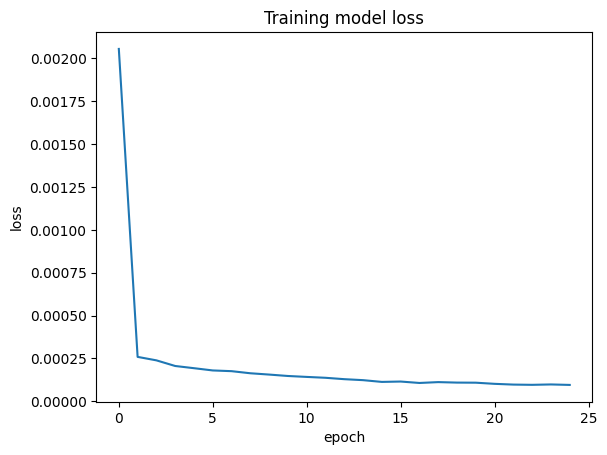

In [ ]:
plt.plot(modelresult.history["loss"])
plt.title('Training model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
#predicted stock price on train and test data
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

73/73 [==============================] - 1s 7ms/step


In [ ]:
#Inverse transform to get the actual values
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

In [ ]:
train_pred

array([[ 3.5659275],
       [ 3.610098 ],
       [ 3.6591706],
       ...,
       [38.04939  ],
       [37.815434 ],
       [37.697353 ]], dtype=float32)

We check our predictions of the closing price based on the training set and then display the first 5 rows

In [ ]:
P_train=df[time_step:len(train_pred)+time_step]
P_train = pd.DataFrame(train_pred, index = P_train.index, columns = ["Predicted_Close"])
len(P_train)

9551

In [ ]:
P_train.head()

,Predicted_Close
Date,
1972-10-23,3.565928
1972-10-24,3.610098
1972-10-25,3.659171
1972-10-26,3.705921
1972-10-27,3.744961


We check our predictions of the closing price based on the test set and then display the last 5 rows

In [ ]:
P_test=df[-len(test_pred):]
P_test = pd.DataFrame(test_pred, index = P_test.index, columns = ["Predicted_Close"])
len(P_test)

2313

In [ ]:
P_test.tail()

,Predicted_Close
Date,
2020-03-26,66.422943
2020-03-27,68.157288
2020-03-30,70.359795
2020-03-31,72.426575
2020-04-01,73.826820


Plot our predicted stock prices and the actual stock prices to compare the predictions of our LSTM Model

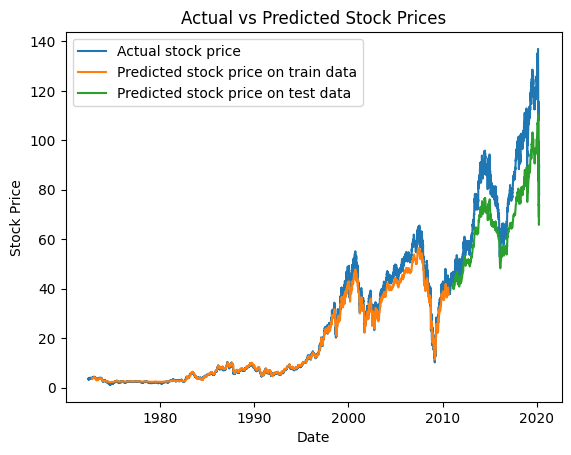

In [ ]:
#plt.plot(scaler.inverse_transform(df1), label = "Actual stock price")
plt.plot(df, label = "Actual stock price")
plt.plot(P_train, label = "Predicted stock price on train data")
plt.plot(P_test, label = "Predicted stock price on test data")

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

# Forecasting Stock price for the next 30 days

We take the latest 100 values and then predict the closing stock price for the next 30 days

In [ ]:
len(test_data)

2413

In [ ]:
#Extracting the last 100 days from the test data
pred_inp = test_data[-100:]

In [ ]:
len(pred_inp)

100

In [ ]:
pred_inp = pred_inp.reshape(1,-1)

In [ ]:
pred_inp.shape

(1, 100)

In [ ]:
inp_list = list(pred_inp)

In [ ]:
#Creating list of the last 100 data
inp_list = inp_list[0].tolist()

In [ ]:
#Predicting next 30 days closing price using the current data
#It will predict in sliding window method (algorithm) with stride 1 (we shift by 1 to have 101 values)
pred_output=[]
n_steps=100
i=0
while(i<30): # we repeat it 30 times (sliding window algorithm)

    if(len(inp_list)>100):
        pred_inp = np.array(inp_list[1:])
        pred_inp = pred_inp.reshape(1,-1)
        pred_inp = pred_inp.reshape((1, n_steps, 1))
        future_stock = model.predict(pred_inp, verbose=0)
        inp_list.extend(future_stock[0].tolist())
        inp_list = inp_list[1:]
        pred_output.extend(future_stock.tolist())
        i=i+1
    else:
        pred_inp = pred_inp.reshape((1, n_steps,1))
        future_stock = model.predict(pred_inp, verbose=0)
        inp_list.extend(future_stock[0].tolist())
        pred_output.extend(future_stock.tolist())
        i=i+1


print(pred_output)

[[0.5336157083511353], [0.5204989910125732], [0.5003117918968201], [0.477904736995697], [0.46006250381469727], [0.44441863894462585], [0.4316292107105255], [0.42170003056526184], [0.41446560621261597], [0.4094979166984558], [0.40562891960144043], [0.40235427021980286], [0.39927205443382263], [0.3960958421230316], [0.39285141229629517], [0.38955897092819214], [0.3858497738838196], [0.381786972284317], [0.3774537146091461], [0.37293553352355957], [0.3683106303215027], [0.36364439129829407], [0.3589881956577301], [0.35437890887260437], [0.349841445684433], [0.3453899919986725], [0.34103143215179443], [0.3367672860622406], [0.33259567618370056], [0.3285132646560669]]


In [ ]:
len(pred_output)

30

In [ ]:
#convert the predictions to actual values
pred_stock = scaler.inverse_transform(pred_output)
pred_stock

array([[73.59712632],
       [71.81593574],
       [69.07460588],
       [66.0318297 ],
       [63.60893556],
       [61.48456983],
       [59.74782363],
       [58.39948611],
       [57.41708417],
       [56.74249452],
       [56.21710231],
       [55.77241981],
       [55.35386892],
       [54.92255373],
       [54.48197491],
       [54.03487634],
       [53.53118425],
       [52.97947426],
       [52.39103757],
       [51.77748912],
       [51.14944829],
       [50.51579425],
       [49.88350405],
       [49.25758386],
       [48.64141699],
       [48.03692982],
       [47.44505721],
       [46.86600556],
       [46.2995199 ],
       [45.74514698]])

In [ ]:
#convert the array to Pandas Dataframe
pred_stock = pd.DataFrame(pred_stock,columns=["Predictions"])
pred_stock

,Predictions
0,73.597126
1,71.815936
2,69.074606
3,66.031830
4,63.608936
5,61.484570
6,59.747824
7,58.399486
8,57.417084
9,56.742495


We create new dates for our next 30 prediction starting from the last date of our test data and we index the date in a new dataframe against our predictions

In [ ]:
#get last date from df
curr_date = df.index[-1]

from datetime import timedelta
new_data = []
for i in range(30):
  curr_date = curr_date + timedelta(days=1)
  new_data.append({'Predictions':pred_stock["Predictions"][i], "Date": curr_date})

In [ ]:
new_data = pd.DataFrame(new_data).set_index("Date")

In [ ]:
#check our predictions with the dates
new_data

,Predictions
Date,
2020-04-02,73.597126
2020-04-03,71.815936
2020-04-04,69.074606
2020-04-05,66.031830
2020-04-06,63.608936
2020-04-07,61.484570
2020-04-08,59.747824
2020-04-09,58.399486
2020-04-10,57.417084


Visualize actual data with the stock price prediction of 30 days

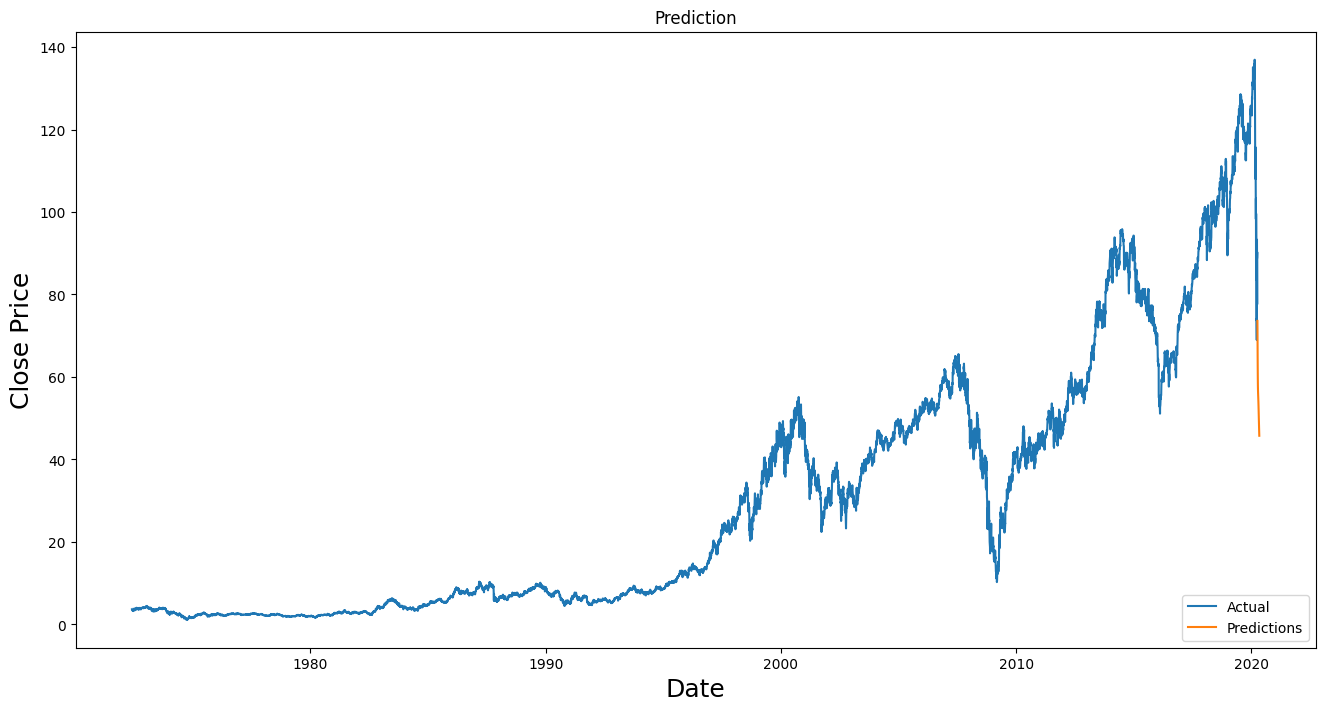

In [ ]:
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(df['Close'])
plt.plot(new_data['Predictions'])
plt.legend(['Actual', 'Predictions'], loc='lower right')
plt.show()

We zoom into our plot and visualize the last 500 days of the actual closing stock price with next 30 days of stock price prediction

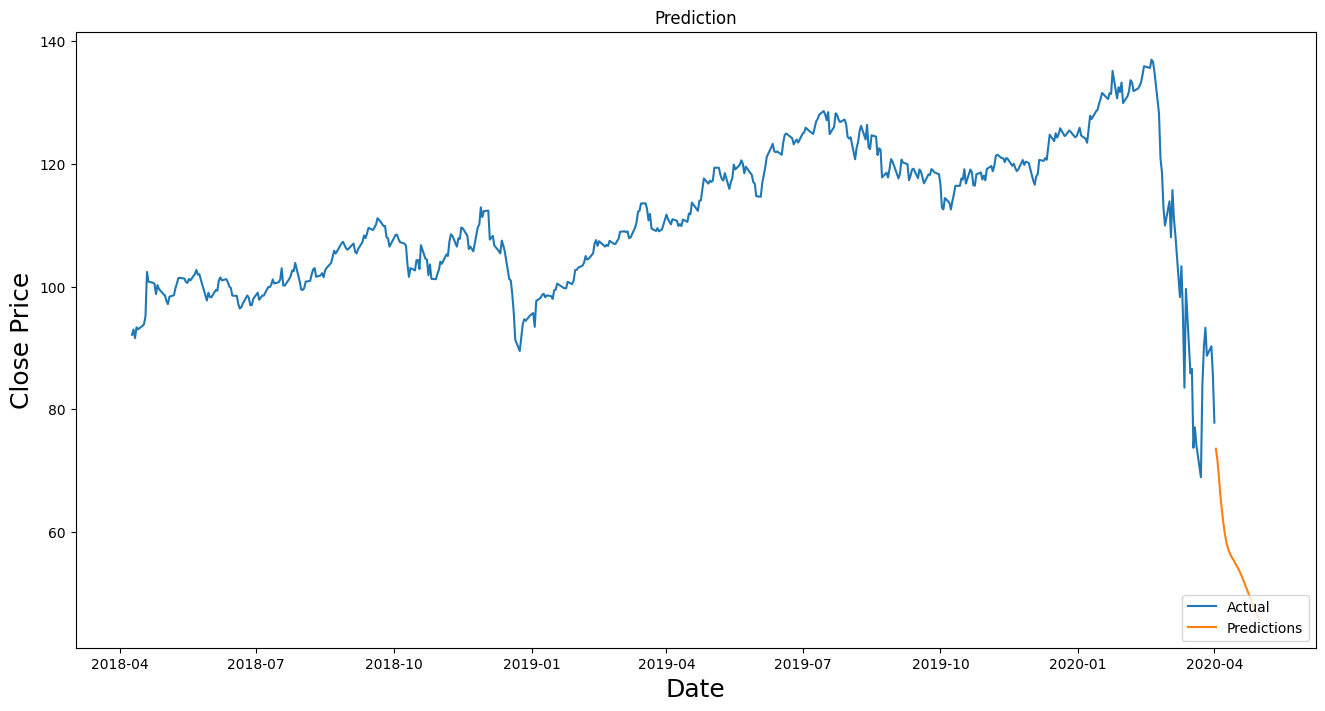

In [ ]:
#we take the last 500 stock closing price from our actual data to see the evolution and our prediction of the next 30 days.
df_recent =df[-500:]

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(df_recent['Close'])
plt.plot(new_data['Predictions'])
plt.legend(['Actual', 'Predictions'], loc='lower right')
plt.show()

Plot prediction of next month close for AXP

In [ ]:
#we extend our actual data with the prediction output
ds_new = df1.tolist()
ds_new.extend(pred_output)

In [ ]:
#Creating final data for plotting
final_graph = scaler.inverse_transform(ds_new).tolist()

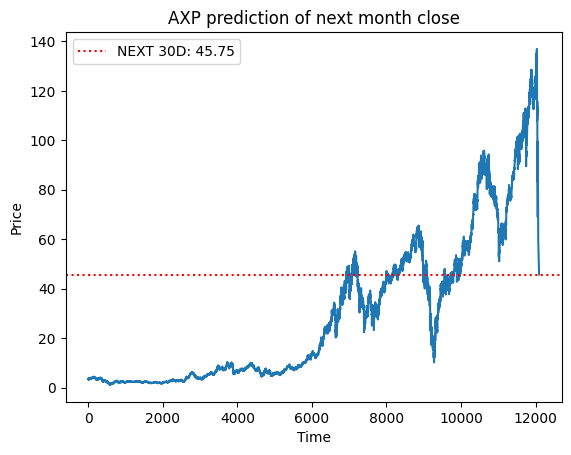

In [ ]:
#Plotting final results with predicted value after 30 Days

stock_symbol = "AXP"
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month close".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

# Evaluate Performance metrics

In [ ]:
# Calculate and print additional performance metrics such as RMSE, Mean Absolute Error (MAE).
from sklearn.metrics import mean_squared_error, mean_absolute_error


train_rmse = mean_squared_error(y_train, train_pred, squared=False)
test_rmse = mean_squared_error(y_test, test_pred, squared=False)

train_mae = mean_absolute_error(y_train, train_pred)
test_mae = mean_absolute_error(y_test, test_pred)

print("Train RMSE: %.2f" % train_rmse)
print("Test RMSE: %.2f" % test_rmse)
print("Train MAE: %.2f" % train_mae)
print("Test MAE: %.2f" % test_mae)


Train RMSE: 22.83
Test RMSE: 67.92
Train MAE: 16.46
Test MAE: 66.09
